In [24]:
# Imports
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
# enable interactive plots
import matplotlib.pyplot as plt,mpld3
mpld3.enable_notebook()
from pylab import rcParams
rcParams['figure.figsize'] = (9.0, 5.0)
import numpy as np
from IPython.html.widgets import interactive
from IPython.display import display
from scipy import signal

## Background
In this lab, we will go through the steps in the communication signal processing chain (excluding modulation and demodulation). 

### Step 1: Signal Creation
For the sake of example, we will use the same random signals we used in the filtering module to represent the basband communications signal.  The difference is that we are free to modulate a complex signal in baseband.  This allows us to use more bits per second.  


[-2, 2, -2, 2]

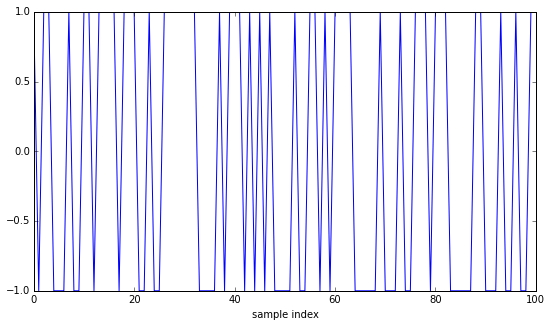

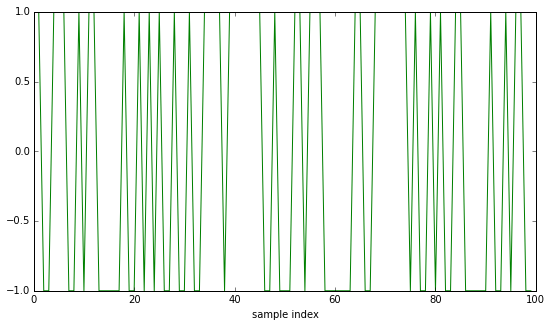

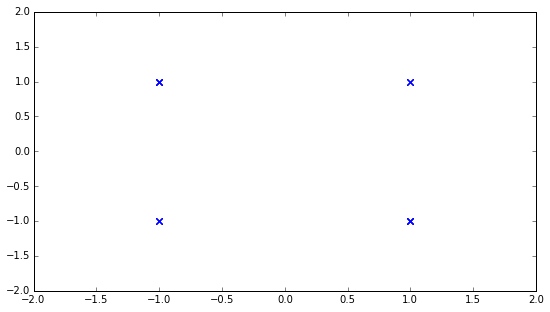

In [25]:
num_samples = 100

# set seed value (optional)
np.random.seed(10)

# generate numpy array of random numbers
# x_real = np.random.rand(num_samples)-0.5
# x_imag = np.random.rand(num_samples)-0.5
x_real = np.round(np.random.rand(num_samples))*2-1
x_imag = np.round(np.random.rand(num_samples))*2-1
x = x_real + 1j*x_imag

# plot
plt.figure(1)
plt.plot(x_real,'b');
plt.xlabel('sample index');
plt.figure(2)
plt.plot(x_imag,'g');
plt.xlabel('sample index');
plt.figure(3)
plt.plot(x_real,x_imag,'x');
plt.axis([-2,2,-2,2])

### Step 2: DAC Conversion & Oversampling
The first step in DAC is to determine the sample rate.  For this eample, let's assume a sample rate of 1000 samples per second.  That means that our 100 sample signal only takes up 0.1s worth of time. 

Since it is cumbersome to work with continous-time signals on a computer, we need a second step where we approximate the continous-time signal with an oversampled version of the discrete-time signal.  To accomplish this we will oversample by a factor of 40.

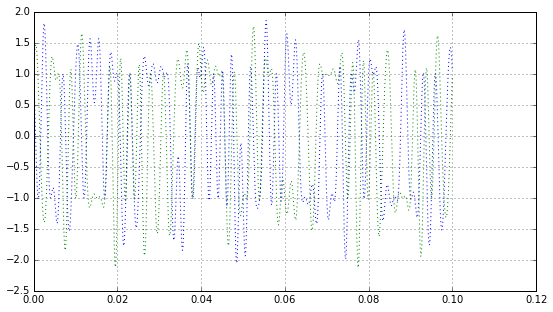

In [26]:
factor = 40
continuous_samples = x.size*factor
x_continuous_real = signal.resample(x_real,continuous_samples)
x_continuous_imag = signal.resample(x_imag,continuous_samples)

x_continuous = x_continuous_real + 1j*x_continuous_imag
time_range = np.linspace(0,0.1,continuous_samples)
plt.plot(time_range,x_continuous_real,'b:');
plt.plot(time_range,x_continuous_imag,'g:');
plt.grid(True)

### Step 3: Look at the Spectrum
Zoom in and notice that the spectrum is not symmetric.  Why not?

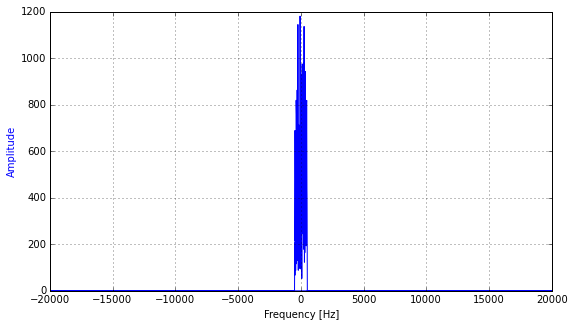

In [27]:
sample_rate = factor*1000

# Calculate DFT
spectrum = np.fft.fft(x_continuous)

# DFT frequencies
freq = np.fft.fftfreq(x_continuous.size)

# plot FFT
plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'b');
plt.ylabel('Amplitude', color='b');
plt.xlabel('Frequency [Hz]');
plt.grid(True)

### Step 4: Upconversion Carrier Signal
After going through the fitler module, upconversion is fairly straightforward.  We simply need to multiple the baseband signal by $c(t) = \cos(2 \pi f_c t)$

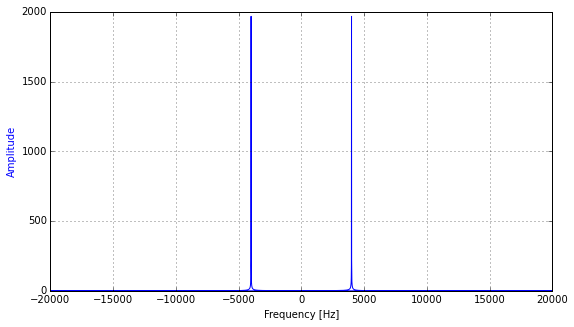

In [28]:
f_c = 4000
carrier_signal = np.cos(2*np.pi*f_c*time_range)

# Calculate DFT
spectrum = np.fft.fft(carrier_signal)

# DFT frequencies
freq = np.fft.fftfreq(carrier_signal.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'b');
plt.ylabel('Amplitude', color='b');
plt.xlabel('Frequency [Hz]');
plt.grid(True)

### Step 6: Upconversion
The next step is to just multiply the carrier signal by the baseband signal.  Obviously in practice this happens in the continuous time domain and the clock is generated from an analog source.



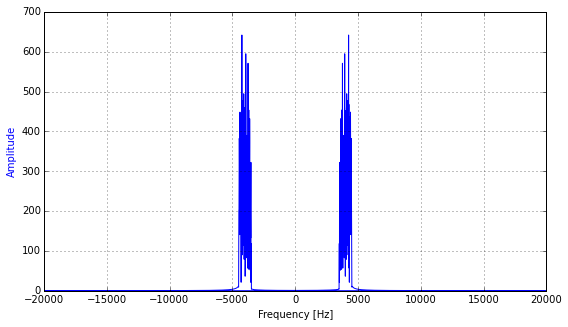

In [29]:
passband_signal = x_continuous_real*np.cos(2*np.pi*f_c*time_range) - x_continuous_imag*np.sin(2*np.pi*f_c*time_range)

# Calculate DFT
spectrum = np.fft.fft(passband_signal)

# DFT frequencies
freq = np.fft.fftfreq(passband_signal.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'b');
plt.ylabel('Amplitude', color='b');
plt.xlabel('Frequency [Hz]');
plt.grid(True)

### Step 7: Down Conversion
At the receiver, the I and Q of the passband signal are separately processed in order to recover the orignal baseband signal.

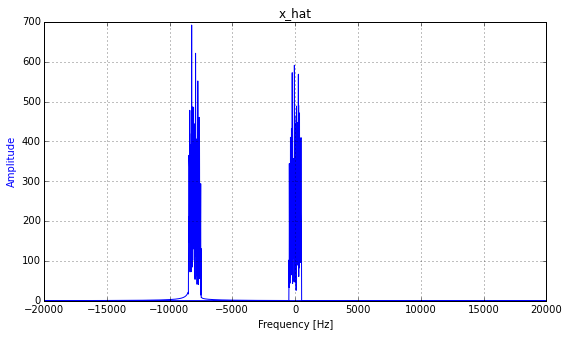

In [30]:
x_hat_I = passband_signal*np.cos(2*np.pi*f_c*time_range)
x_hat_Q = passband_signal*np.sin(2*np.pi*f_c*time_range)

x_hat = x_hat_I - 1j*x_hat_Q

# Calculate DFT
spectrum = np.fft.fft(x_hat)

# DFT frequencies
freq = np.fft.fftfreq(x_hat.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'b');
plt.ylabel('Amplitude', color='b');
plt.xlabel('Frequency [Hz]');
plt.title('x_hat')
plt.grid(True)



### Step 8: Filter and Compare
Filter the baseband signal, then compare in frequency and time.  The signal is slightly compressed, but it is almost identical to the transmitted signal--as expected.

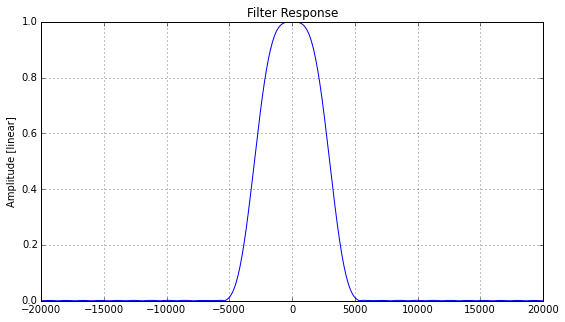

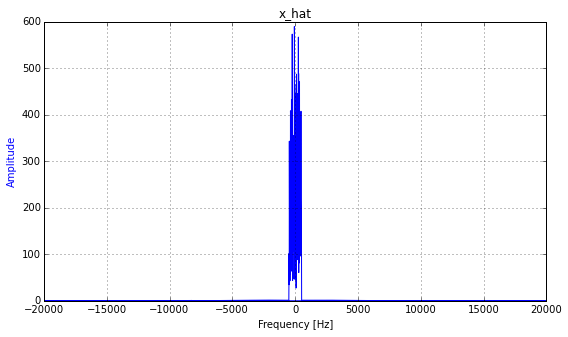

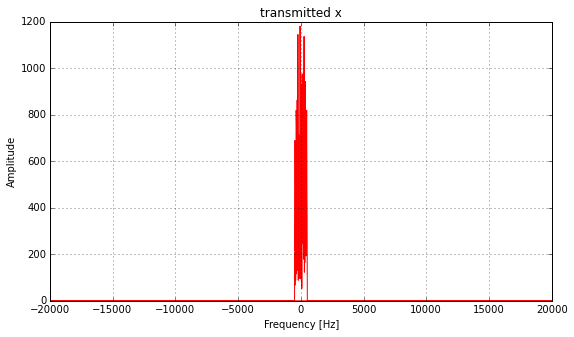

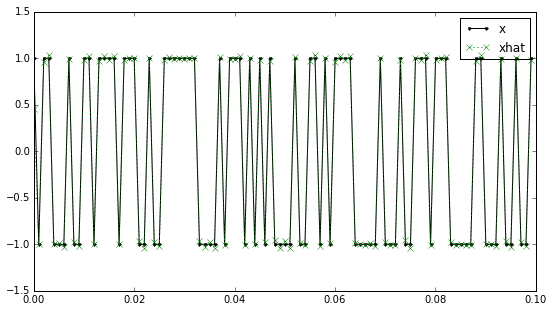

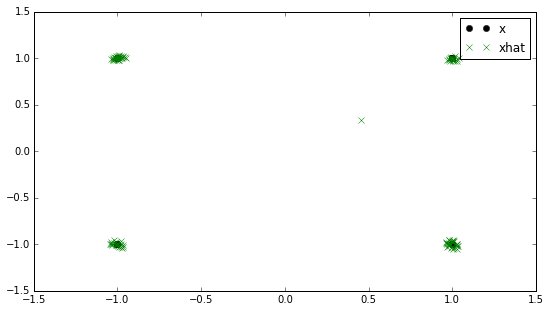

In [31]:
fs = factor*1000
h = signal.firwin(30,6000,nyq=fs)

omega_hat, response = signal.freqz(h, worN=np.linspace(-np.pi,np.pi,500))
plt.figure(0)
plt.plot(omega_hat/np.pi*fs/2,abs(response));
plt.grid(True)
plt.ylabel('Amplitude [linear]')
plt.title('Filter Response')

x_hat_filtered = signal.convolve(x_hat,h,mode='same')

# Calculate DFT
spectrum = np.fft.fft(x_hat_filtered)

# DFT frequencies
freq = np.fft.fftfreq(x_hat_filtered.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'b');
plt.ylabel('Amplitude', color='b');
plt.xlabel('Frequency [Hz]');
plt.title('x_hat')
plt.grid(True)

# Calculate DFT
spectrum = np.fft.fft(x_continuous)

# DFT frequencies
freq = np.fft.fftfreq(x_continuous.size)

plt.figure(2)
plt.plot(freq*sample_rate, abs(spectrum), 'r');
plt.ylabel('Amplitude');
plt.xlabel('Frequency [Hz]');
plt.title('transmitted x')
plt.grid(True)

# compare in time domain
plt.figure(4)
plt.plot(time_range[::factor],x, 'k.-', label='x');
plt.plot(time_range[::factor],2*x_hat_filtered[::factor], 'gx:', label='xhat');
plt.legend();

# compare in complex plane
plt.figure(5)
plt.plot(np.real(x),np.imag(x), 'ko', label='x');
plt.plot(np.real(2*x_hat_filtered[::factor]),np.imag(2*x_hat_filtered[::factor]), 'gx', label='xhat');
plt.legend();


### Step 9: Non-Ideal Clock
As we saw in the lecture slides, if the clock signal is not a pure tone, then trouble arises. Let's assume that there is a second signal on the air at 12kHz and see what happens when the oscillator is a square wave.

#### Step 9a: Generate Second Signal

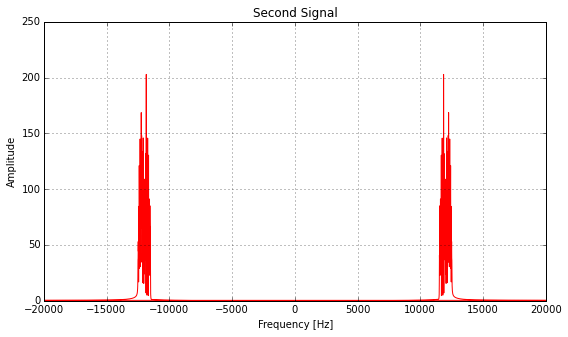

In [32]:

np.random.seed(100)

# generate numpy array of random numbers
x2_real = np.random.rand(num_samples)-0.5
x2_imag = np.random.rand(num_samples)-0.5
x2 = x2_real + 1j*x2_imag


x2_continuous_real = signal.resample(x2_real,continuous_samples)
x2_continuous_imag = signal.resample(x2_imag,continuous_samples)

x2_continuous = x2_continuous_real + 1j*x2_continuous_imag

f_c2 = 12000

passband_signal2 = x2_continuous_real*np.cos(2*np.pi*f_c2*time_range) - x2_continuous_imag*np.sin(2*np.pi*f_c2*time_range)

# Calculate DFT
spectrum = np.fft.fft(passband_signal2)

# DFT frequencies
freq = np.fft.fftfreq(passband_signal2.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'r');
plt.ylabel('Amplitude');
plt.xlabel('Frequency [Hz]');
plt.grid(True)
plt.title('Second Signal');

#### Step 9b: Generate Rx Signal

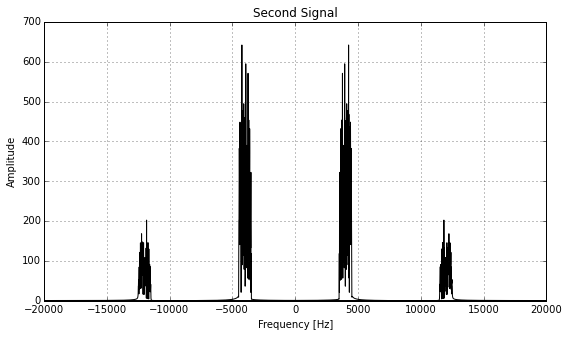

In [33]:
pb_total = passband_signal2 + passband_signal

# Calculate DFT
spectrum = np.fft.fft(pb_total)

# DFT frequencies
freq = np.fft.fftfreq(pb_total.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'k');
plt.ylabel('Amplitude');
plt.xlabel('Frequency [Hz]');
plt.grid(True)
plt.title('Second Signal');

#### Step 9c: Donconvert with Pure Tone

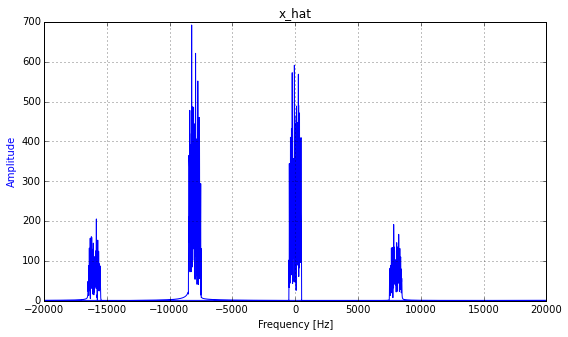

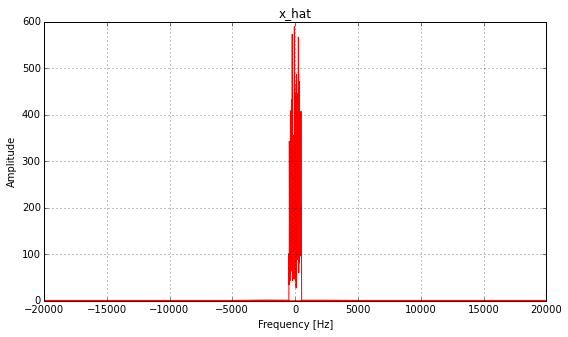

In [34]:
x_hat_I = pb_total*np.cos(2*np.pi*f_c*time_range)
x_hat_Q = pb_total*np.sin(2*np.pi*f_c*time_range)

x_hat = x_hat_I - 1j*x_hat_Q

# Calculate DFT
spectrum = np.fft.fft(x_hat)

# DFT frequencies
freq = np.fft.fftfreq(x_hat.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'b');
plt.ylabel('Amplitude', color='b');
plt.xlabel('Frequency [Hz]');
plt.title('x_hat')
plt.grid(True)


x_hat_filtered = signal.convolve(x_hat,h,mode='same')

# Calculate DFT
spectrum = np.fft.fft(x_hat_filtered)

# DFT frequencies
freq = np.fft.fftfreq(x_hat_filtered.size)

plt.figure(2)
plt.plot(freq*sample_rate, abs(spectrum), 'r');
plt.ylabel('Amplitude');
plt.xlabel('Frequency [Hz]');
plt.title('x_hat')
plt.grid(True)

#### Step 9d: Donconvert with Square Wave

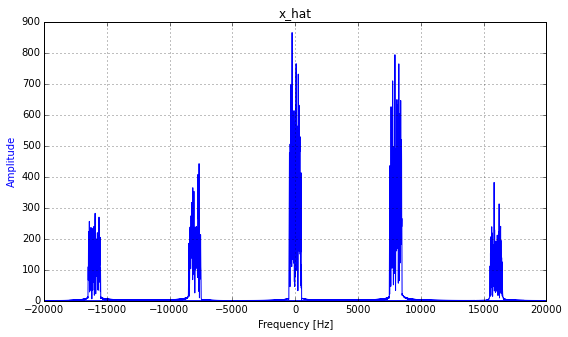

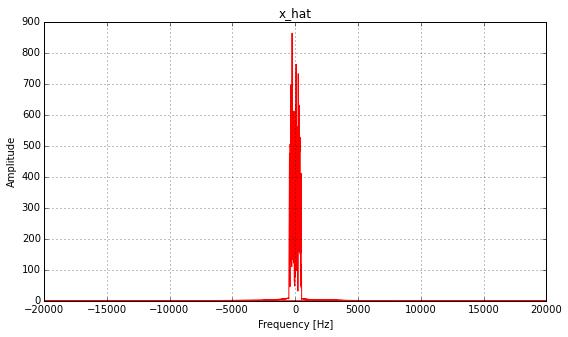

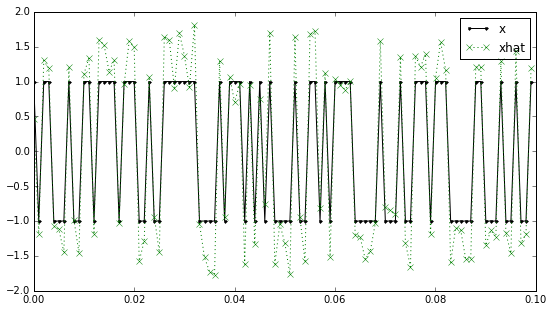

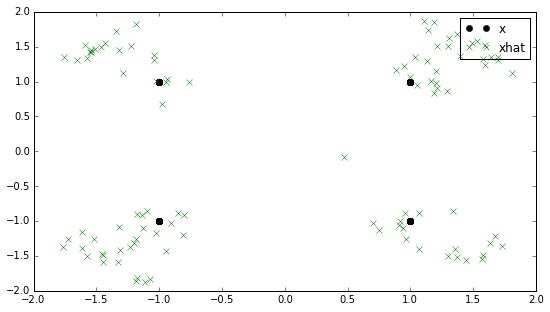

In [35]:
x_hat_I = pb_total*signal.square(2*np.pi*f_c*time_range+np.pi/2)
x_hat_Q = pb_total*signal.square(2*np.pi*f_c*time_range+np.pi)

x_hat = x_hat_I - 1j*x_hat_Q

# Calculate DFT
spectrum = np.fft.fft(x_hat)

# DFT frequencies
freq = np.fft.fftfreq(x_hat.size)

plt.figure(1)
plt.plot(freq*sample_rate, abs(spectrum), 'b');
plt.ylabel('Amplitude', color='b');
plt.xlabel('Frequency [Hz]');
plt.title('x_hat')
plt.grid(True)


x_hat_filtered = signal.convolve(x_hat,h,mode='same')

# Calculate DFT
spectrum = np.fft.fft(x_hat_filtered)

# DFT frequencies
freq = np.fft.fftfreq(x_hat_filtered.size)

plt.figure(2)
plt.plot(freq*sample_rate, abs(spectrum), 'r');
plt.ylabel('Amplitude');
plt.xlabel('Frequency [Hz]');
plt.title('x_hat')
plt.grid(True)


# Plot time domain
plt.figure(4)
plt.plot(time_range[::factor],x, 'k.-', label='x');
plt.plot(time_range[::factor],2*x_hat_filtered[::factor], 'gx:', label='xhat');
plt.legend();


# compare in complex plane
plt.figure(5)
plt.plot(np.real(x),np.imag(x), 'ko', label='x');
plt.plot(np.real(2*x_hat_filtered[::factor]),np.imag(2*x_hat_filtered[::factor]), 'gx', label='xhat');
plt.legend();
